## Imports

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import sparse
from surprise import Dataset, Reader, SVD
from collections import Counter

In [27]:
interaction = pd.read_csv("training_data/data.csv")
interaction.head()

,user_id,song_id,interaction,listen_count,timestamp
0,34,8,1,1,2024-09-05 10:50:02.189760
1,13,198,0,4,2024-05-30 10:50:02.189780
2,1,9,2,1,2024-11-15 10:50:02.189783
3,36,91,1,1,2024-08-15 10:50:02.189785
4,15,92,1,3,2024-02-08 10:50:02.189787


## Data Analysis and Preprocessing

### User Behaviour Analysis

Average number of listens per user: 19.2
Most active users: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] and Most Inactive Users: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


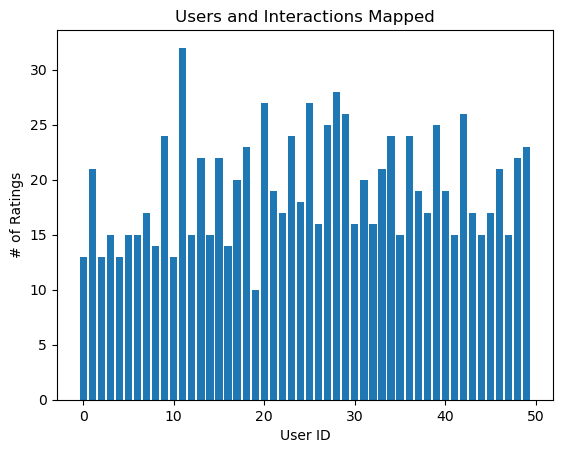

In [231]:
# users = Counter(sorted(interaction["user_id"]))
users = interaction["user_id"].value_counts()

# plot user interactions
plt.title("Users and Interactions Mapped")
plt.bar(users.index,users.values)
plt.xlabel("User ID")
plt.ylabel("# of Ratings")

# average listens per user
average_ratings_per_user = users.mean()
print("Average number of listens per user:",average_ratings_per_user)

# top 10 active/inactive users
listencount_users = interaction.groupby("user_id")["listen_count"].sum()
top_active_users = list(sorted_users.index[:10])
top_inactive_users = list(sorted_users.index[-10:])
print(f'Most active users: {top_active_users} and Most Inactive Users: {top_inactive_users}')


### Song Analysis

Number of unique songs: 198
Number of unlistened songs: 0
Most played songs: [40, 191, 183, 190, 45] and Least played songs: [4, 171, 43, 193, 114]


Text(0, 0.5, 'Number of Listens')

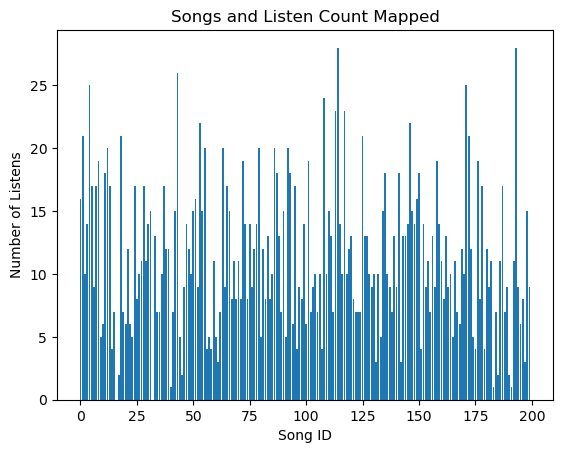

In [227]:
songs = interaction["song_id"]

# number of songs
unique_songs = songs.nunique()
print(f'Number of unique songs: {unique_songs}')

# check for unrated songs
listen_count = (interaction.groupby(["song_id"])["listen_count"].sum())
unplayed = (listen_count ==0).sum()
print(f'Number of unlistened songs: {unplayed}')

#top 5 most/least played songs
sorted_listen_count = listen_count.sort_values(ascending=True)
top_played_songs = list(sorted_listen_count.index[:5])
least_played_songs = list(sorted_listen_count.index[-5:])
print(f'Most played songs: {top_played_songs} and Least played songs: {least_played_songs}')


# plot listen counts
plt.title("Songs and Listen Count Mapped")
plt.bar(listen_count.index, listen_count.values)
plt.xlabel("Song ID")
plt.ylabel("Number of Listens")


### Rating Patterns

### Matrix Sparsity